In [1]:
from models import MeshModel, IcosphereModel
from jax.typing import ArrayLike
from models.mesh_transform import add_rotation, evaluate_rotation
from models.spots import add_spots
from plots import plot_3D
from spectrum import simulate_spectrum
import astropy.units as u
import astropy.constants as const
import jax.numpy as jnp
import numpy as np
from transformer_payne import TransformerPayne, BlackbodyFlux

from jax import config
config.update("jax_enable_x64", True)

I0000 00:00:1709611586.236346       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
base_temp = 5700
spot_temp = 20000
spot_diff = spot_temp - base_temp

In [3]:
bb = BlackbodyFlux()

In [4]:
m = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., bb.to_parameters(dict(teff=base_temp)))
ms = add_spots(mesh=m,
              thetas=jnp.array([1.]),
              phis=jnp.array([0.]),
              param_deltas=jnp.array([spot_diff]),
              radii=jnp.array([0.25]),
              radius_factors=jnp.array([.75]),
              param_indices=jnp.array([0]))

/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [5]:
mt = add_rotation(m, 100, jnp.array([0., 0., 1.]))
mts = [evaluate_rotation(mt, t) for t in np.linspace(0, 3600*10, 10)]

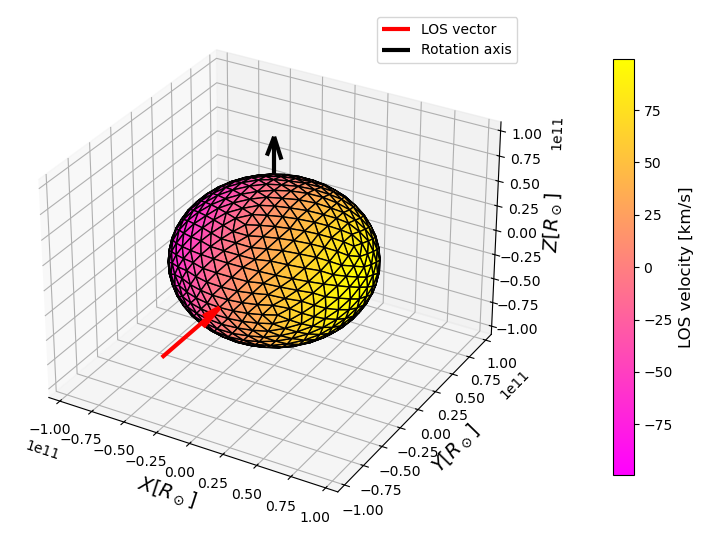

In [6]:
_, _ = plot_3D(mts[0], 'los_velocities', cmap='spring')

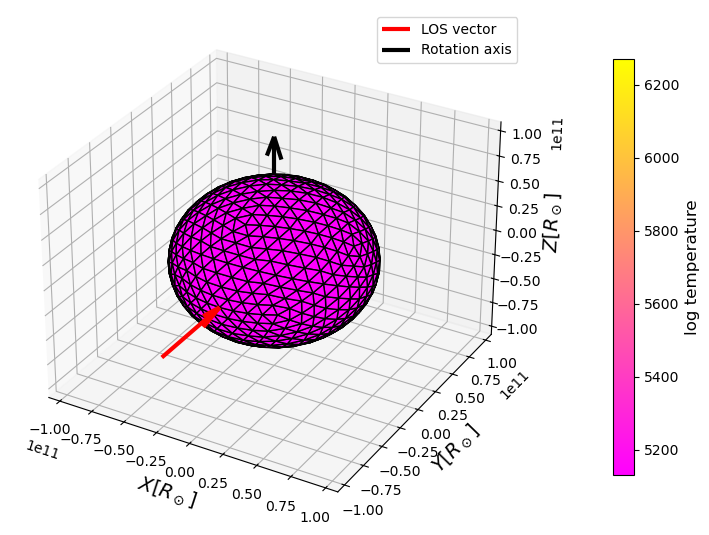

In [7]:
_, _ = plot_3D(mts[0], 0, cmap='spring', property_label='log temperature')

In [8]:
import matplotlib.pyplot as plt

vws = jnp.linspace(4000., 6000., 100)

In [9]:
s = bb.intensity(jnp.log10(vws), 1., 5700)

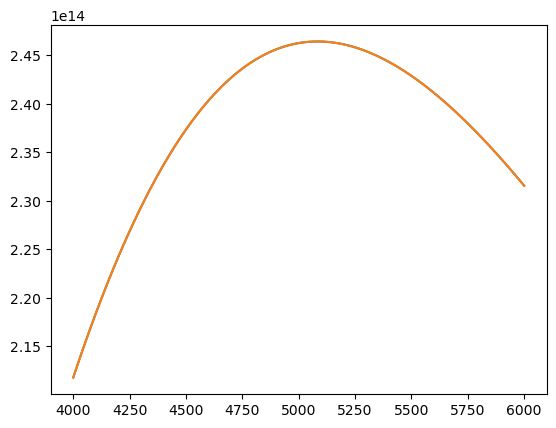

In [10]:
plt.plot(vws, s)

In [11]:
from spectrum.spectrum import spectrum_flash_sum

In [14]:
spec = spectrum_flash_sum(bb.intensity, jnp.log10(vws), m.areas,
                          jnp.where(m.mus>0, m.mus, 0.),
                          m.los_velocities,
                          m.parameters.astype(jnp.float64),
                          1024)
plt.plot(vws, spec[:, 0])

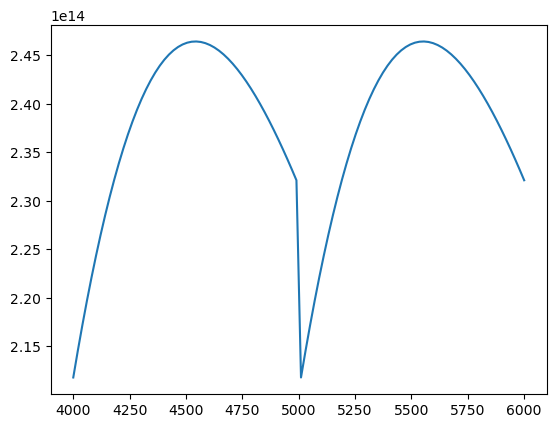

In [29]:
plt.plot(vws, spec[:, 0])

In [14]:
i = simulate_spectrum(tp.intensity, m, jnp.log10(vws))
plt.plot(vws, i[:, 0], color='red', alpha=0.5)

for _mt in mts:
    i = simulate_spectrum(tp.intensity, _mt, jnp.log10(vws), 16)
    plt.plot(vws, i[:, 1], color='black', alpha=0.5)

plt.gca().set_ylim(0, 1e7)

KeyboardInterrupt: 

In [11]:
jnp.sum(i[:, 0])

Array(88048522.17842747, dtype=float64)